<a href="https://colab.research.google.com/github/Math108/pln/blob/main/Seminario_Pln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Retrieval-Augmented Generation é um novo método que utiliza LLMs para automatizar buscas, sinteses, extração e planejamento de fontes de dados desestruturadas. Esse método ganhou relevância nos últimos anos devido a sua capacidade de potencializar LLMs utilizando informações contextuais. A pilha de dados de um RAG consiste de:
- Carregamento de dados
- Processamento de dados
- Embedding
- Database de vetores
- Recuperação e Prompting

Apesar do seu poder em auxiliar LLMs, a utilização de RAGs possui alguns problemas:
- Resultados não são acurados suficiente
- Número elevado de parâmetros
- PDFs são um problema
- Sincronização de dados é um desafio

Com o objetivo de solucionar esses problemas, a LlamaIndex criou o LlamaCloud e o LlamaParse, com o intuito de melhorar e potencializar o contexto com que as LLMs e RAGs conseguem trabalhar.
O principal intuito por tras da introdução do LlamaCloud foi possibilitar um maior foco na lógica de negócios, e não em como lidar com os dados em si.

# LlamaParse

O LlamaParse é um serviço especializado no parsing de PDFs com tabelas complexas em uma estrutura de dados bem estruturada. No momento, o suporte primário é para PDFs com tabelas, porém estão trabalhando em melhorar o suporte para figuras e para outros tipos populares de documentos, como .docx, .ppx e .html.

#Groq LPU

A Unidade de Processamento de Linguagem do Groq é uma tecnologia de última geração criado para aprimorar o poder de computação de IAs, especialmente para LLMs. Seu objetivo primário é prover experiencias em tempo real, com baixa latência com um poder excepcional de inferência. Isso o faz extremamente eficiente para tarefas como criação de linguagem natural e seu entendimento.



# Código


Nesta parte do código, instalaremos as depêndencias do projeto.

In [14]:
%%writefile requirements.txt
langchain
langchain-community
llama-parse
fastembed
chromadb
python-dotenv
langchain-groq
chainlit
fastembed
unstructured[md]
nltk

Overwriting requirements.txt


In [15]:
%%writefile setup_nltk.py
import nltk
import os

# Baixar o recurso 'punkt' necessário para tokenização
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Definir o caminho dos dados do NLTK
nltk_data_path = os.path.join(os.getenv('HOME'), 'nltk_data')

# Se o diretório não existir, criá-lo
os.makedirs(nltk_data_path, exist_ok=True)

# Adicionar o caminho dos dados do NLTK
nltk.data.path.append(nltk_data_path)

Overwriting setup_nltk.py


In [16]:
!pip install -q -U -r requirements.txt


In [1]:
!python setup_nltk.py

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Aqui, configuramos as chaves para as APIs gratuitas que serão utilizadas

In [2]:
from google.colab import userdata

llamaparse_api_key = userdata.get('LLAMA_CLOUD_API_KEY')
groq_api_key = userdata.get("GROQ_API_KEY")

E importamos as dependencias necessárias

In [3]:
##### LLAMAPARSE #####
from llama_parse import LlamaParse

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
#
from groq import Groq
from langchain_groq import ChatGroq
#
import joblib
import os
import nest_asyncio  # noqa: E402
nest_asyncio.apply()

Os parâmatros do LlamaParse que podemos configurar são:

- API Key: A chave da API LlamaParse
- Base URL: a url base da API
- Result Type: O tipo de retorno do parser, no caso será no formato markdown
- Num Workers: O número de threads que irão enviar as requisições de parsing para a API
- Check Interval: O intervalo em segundos para checar se o parsing já foi feito
- Max Timeout: O tempo máximo para esperar pelo parsing
- Verbose: Se desejamos imprimir o progresso do parsing
- Language: A lingua que desejamos utilizar
- parsing_instruction: Uma breve instrução

In [4]:
from pydantic import BaseModel, Field
from typing import Optional
from enum import Enum

# Definindo as enums necessárias
class ResultType(Enum):
    TXT = "txt"
    MARKDOWN = "markdown"

class Language(Enum):
    ENGLISH = "en"
    SPANISH = "es"

# Definindo a URL padrão
DEFAULT_BASE_URL = "https://default-llamaparse-url.com"

# Definindo o modelo com os campos
class LlamaParseConfig(BaseModel):
    api_key: str = Field(
        default="",
        description="The API key for the LlamaParse API.",
    )

    base_url: str = Field(
        default=DEFAULT_BASE_URL,
        description="The base URL of the Llama Parsing API.",
    )

    result_type: ResultType = Field(
        default=ResultType.TXT,
        description="The result type for the parser."
    )

    num_workers: int = Field(
        default=4,
        gt=0,
        lt=10,
        description="The number of workers to use sending API requests for parsing."
    )

    check_interval: int = Field(
        default=1,
        description="The interval in seconds to check if the parsing is done.",
    )

    max_timeout: int = Field(
        default=2000,
        description="The maximum timeout in seconds to wait for the parsing to finish.",
    )

    verbose: bool = Field(
        default=True,
        description="Whether to print the progress of the parsing."
    )

    language: Language = Field(
        default=Language.ENGLISH,
        description="The language of the text to parse."
    )

    parsing_instruction: Optional[str] = Field(
        default="",
        description="The parsing instruction for the parser."
    )

Função utilizada para enviar a requisição de parsing para a API. Se o parsing do arquivo já tiver sido feito, somente o carrega.
Note que para o envio da requisição, alguns campos além do próprio documento são necessários:
- api_key: nossa chave da API
- result_type: o tipo de resultado desejado, no caso, markdown
- parsing_instruction: uma breve descrição do PDF, junto com a instrução do que desejamos que seja feito
- max_timeout: o tempo máximo que desejamos esperar pela resposta

In [5]:
!mkdir data
#
def load_or_parse_data():
    data_file = "./data/parsed_data.pkl"

    if os.path.exists(data_file):
        # Load the parsed data from the file
        parsed_data = joblib.load(data_file)
    else:
        # Perform the parsing step and store the result in llama_parse_documents
        parsingInstructionUber10k = """The provided document is a quarterly report filed by Uber Technologies,
        Inc. with the Securities and Exchange Commission (SEC).
        This form provides detailed financial information about the company's performance for a specific quarter.
        It includes unaudited financial statements, management discussion and analysis, and other relevant disclosures required by the SEC.
        It contains many tables.
        Try to be precise while answering the questions"""
        parser = LlamaParse(api_key=llamaparse_api_key,
                            result_type="markdown",
                            parsing_instruction=parsingInstructionUber10k,
                            max_timeout=5000,)
        llama_parse_documents = parser.load_data("./data/uber_10q_march_2022.pdf")


        # Save the parsed data to a file
        print("Saving the parse results in .pkl format ..........")
        joblib.dump(llama_parse_documents, data_file)

        # Set the parsed data to the variable
        parsed_data = llama_parse_documents

    return parsed_data

Nesta parte, criaremos nossa database de vetores para armazenar os embeddings do PDF fornecido. Para isso, a função faz uma chamada para realizar o parsing do arquivo, e em seguida o converte para o formato markdown (.md). Após isso, definimos o tamanho e o overlap das nossas chunks, e, por fim, realizamos e armazenamos o embedding.

In [6]:
# Create vector database
def create_vector_database():
    """
    Creates a vector database using document loaders and embeddings.

    This function loads urls,
    splits the loaded documents into chunks, transforms them into embeddings using OllamaEmbeddings,
    and finally persists the embeddings into a Chroma vector database.

    """
    # Call the function to either load or parse the data
    llama_parse_documents = load_or_parse_data()
    print(llama_parse_documents[0].text[:300])

    with open('data/output.md', 'a') as f:  # Open the file in append mode ('a')
        for doc in llama_parse_documents:
            f.write(doc.text + '\n')

    markdown_path = "/content/data/output.md"
    loader = UnstructuredMarkdownLoader(markdown_path)

   #loader = DirectoryLoader('data/', glob="**/*.md", show_progress=True)
    documents = loader.load()
    # Split loaded documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=100)
    docs = text_splitter.split_documents(documents)

    #len(docs)
    print(f"length of documents loaded: {len(documents)}")
    print(f"total number of document chunks generated :{len(docs)}")
    #docs[0]

    # Initialize Embeddings
    embed_model = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")

    # Create and persist a Chroma vector database from the chunked documents
    vs = Chroma.from_documents(
        documents=docs,
        embedding=embed_model,
        persist_directory="chroma_db_llamaparse1",  # Local mode with in-memory storage only
        collection_name="rag"
    )

    print('Vector DB created successfully !')
    return vs,embed_model

In [7]:
vs,embed_model = create_vector_database()

Started parsing the file under job_id 31abf564-691e-477a-a2cc-c7d16d19bf01
Saving the parse results in .pkl format ..........
# Quarterly Report - Form 10-Q

# UNITED STATES SECURITIES AND EXCHANGE COMMISSION

# Washington, D.C. 20549

#
# FORM 10-Q

#

(Mark One)

QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the quarterly period ended March 31, 2024

TRANSITION REPORT PURSUA
length of documents loaded: 1
total number of document chunks generated :200


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/218M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

Vector DB created successfully !


Finalmente, criamos o objeto ChatGroq, que permite o processamento da linguagem em si. Para isso:
- Definimos a temperatura como 0
- Especificamos o modelo de linguagem que desejamos usar
- Fornecemos a chave da API


In [8]:
chat_model = ChatGroq(temperature=0,
                      model_name="mixtral-8x7b-32768",
                      api_key=userdata.get("GROQ_API_KEY"),)

In [9]:
 vectorstore = Chroma(embedding_function=embed_model,
                      persist_directory="chroma_db_llamaparse1",
                      collection_name="rag")
 #
 retriever=vectorstore.as_retriever(search_kwargs={'k': 3})

<ipython-input-9-7b41cc38ee75>:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  vectorstore = Chroma(embedding_function=embed_model,


Aqui, criaremos o template para o prompt, informando o modo que queremos receber nossas respostas. Além disso, criamos uma função para ajudar a formatar o prompt.

In [10]:
custom_prompt_template = """Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}
Question: {question}

Only return the helpful answer below and nothing else.
Helpful answer:
"""

In [11]:
def set_custom_prompt():
    """
    Prompt template for QA retrieval for each vectorstore
    """
    prompt = PromptTemplate(template=custom_prompt_template,
                            input_variables=['context', 'question'])
    return prompt
#
prompt = set_custom_prompt()
prompt

PromptTemplate(input_variables=['context', 'question'], template="Use the following pieces of information to answer the user's question.\nIf you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nContext: {context}\nQuestion: {question}\n\nOnly return the helpful answer below and nothing else.\nHelpful answer:\n")

Por fim, instânciamos o modelo de QA, passando o chat_model que criamos previamente e o vectorstore, onde armazenamos os embeddings, e o prompt customizado como parâmetros. Com isso, podemos finalmente realizar perguntas e obter respostas sobre o PDF desejado.

In [12]:
qa = RetrievalQA.from_chain_type(llm=chat_model,
                               chain_type="stuff",
                               retriever=retriever,
                               return_source_documents=True,
                               chain_type_kwargs={"prompt": prompt})

# Exemplos

In [13]:
response = qa.invoke({"query": "What is the Cash Flows from operating activities associated with bad expense specified in the document ?"})
response['result']

'The cash flows from operating activities associated with bad expense specified in the document is not explicitly mentioned. However, the text refers to items such as stock-based compensation expense, unrealized losses on debt and equity securities, net, and depreciation and amortization expense, which are adjusted for in the calculation of net cash provided by operating activities.'

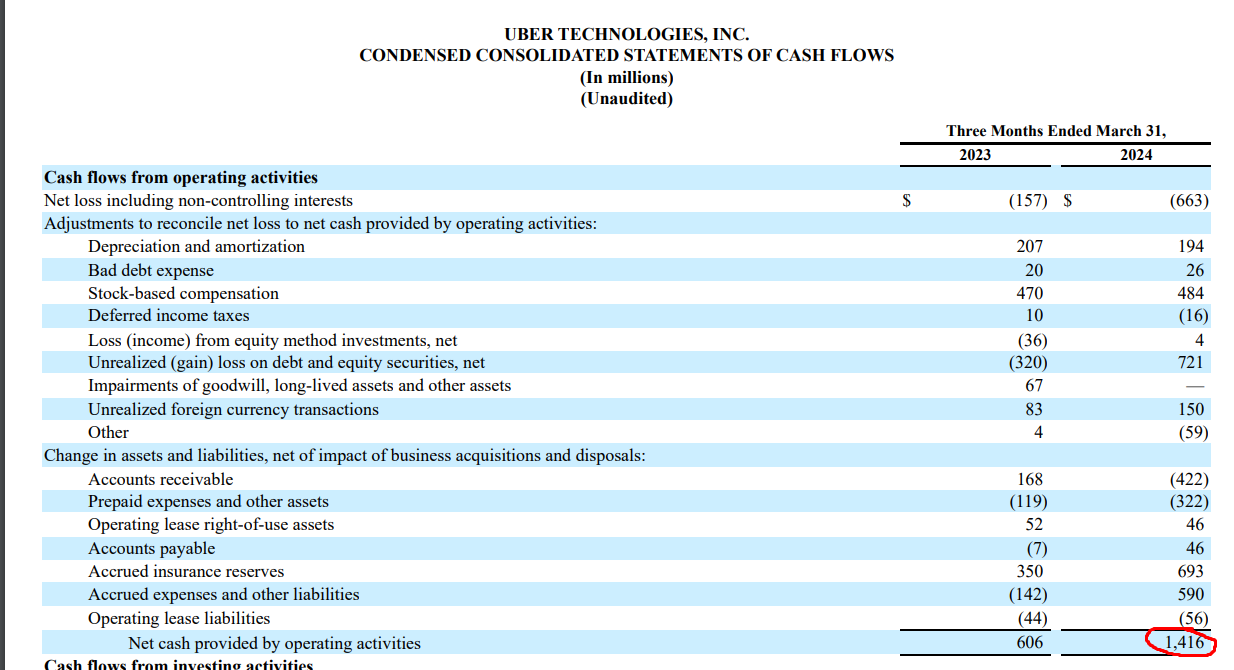

In [ ]:
response = qa.invoke({"query": "what is the Loss (income) from equity method investments, net ? Tell me the value"})
response["result"]

'The loss from equity method investments, net, for the three months ended March 31, 2024 is $(4) million.'

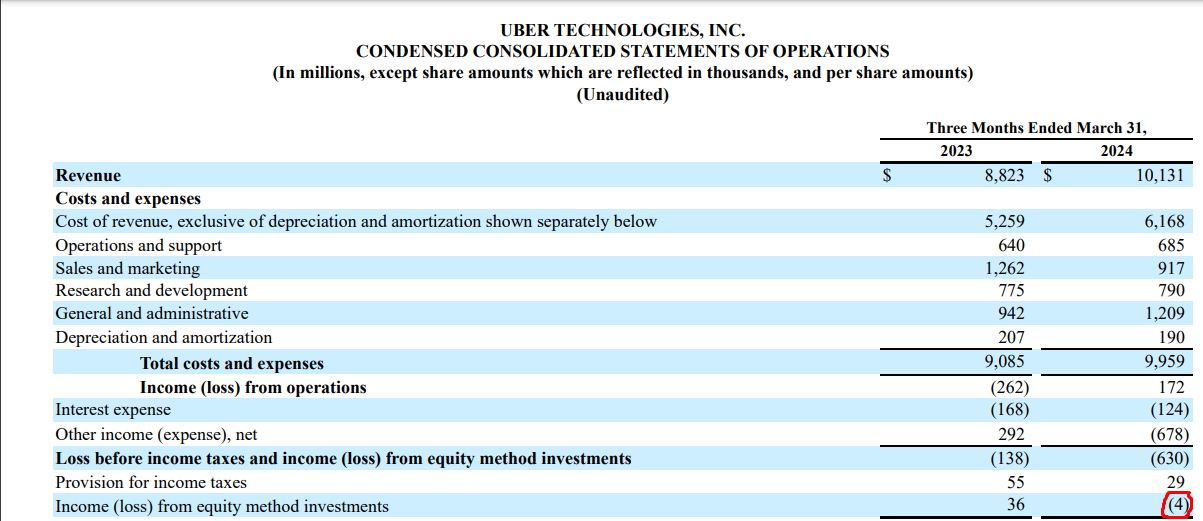

In [ ]:
response = qa.invoke({"query": "What is the Total cash and cash equivalents, and restricted cash and cash equivalents for reconciliation ?"})
response['result']

"The total cash and cash equivalents, and restricted cash and cash equivalents for reconciliation can be found in the company's quarterly report. Specifically, Uber Technologies, Inc. reported $5.0 billion in cash and cash equivalents as of March 31, 2024, however, it is not specified if this amount includes restricted cash and cash equivalents."

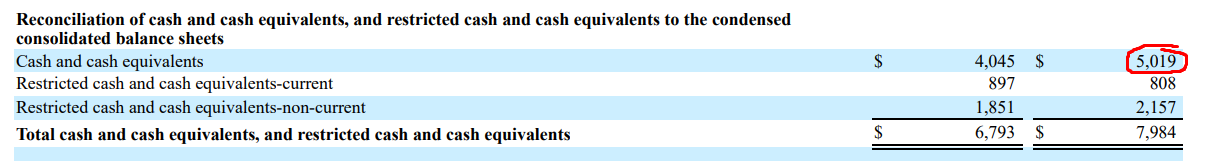

In [ ]:
response = qa.invoke({"query":"Based on the CONDENSED CONSOLIDATED STATEMENTS OF REDEEMABLE NON-CONTROLLING INTERESTS AND EQUITY what is the Balance as of March 31, 2024?"})
response['result']

'The balance of Total equity as of March 31, 2024 is $11,848 million. This includes Common stock, Additional paid-in capital, Accumulated other comprehensive loss, and Accumulated deficit. The balance of Redeemable non-controlling interests as of March 31, 2024 is $651 million. Therefore, the balance of Total liabilities, Redeemable non-controlling interests and equity as of March 31, 2024 is $39,599 million.'

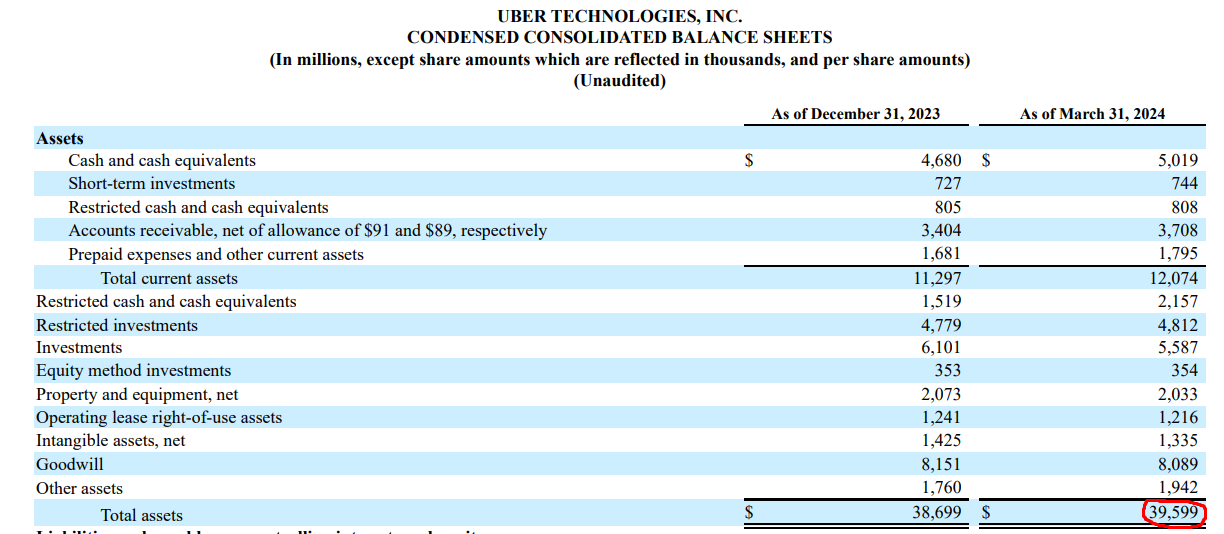

In [ ]:
response = qa.invoke({"query":"Based on the condensed consolidated statements of comprehensive Income(loss) what is the  Comprehensive income (loss) attributable to Uber Technologies, Inc.for the three months ended March 31, 2024"})
response['result']

'The Comprehensive loss attributable to Uber Technologies, Inc. for the three months ended March 31, 2024 is $(654) - $(9) = $(645)$.'

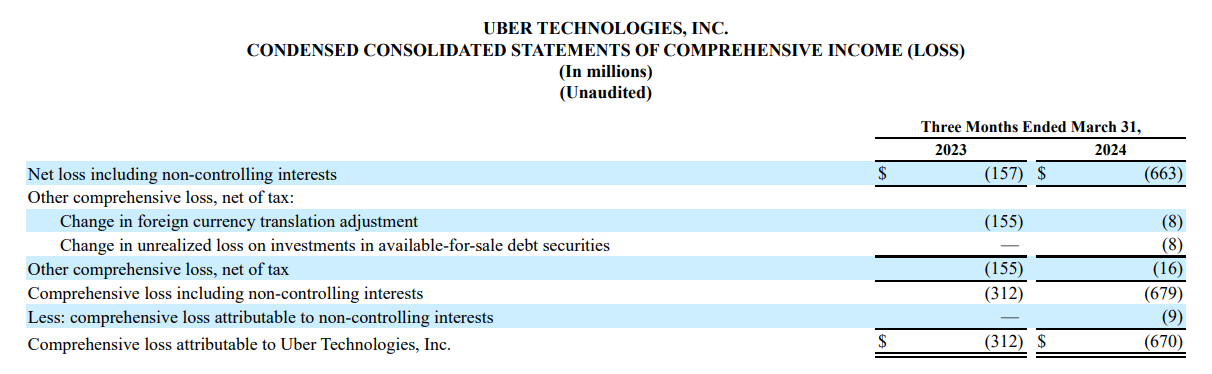

No teste acima obtivemos uma resposta incorreta, interessante notar que o número 645 não aparece nenhuma vez no PDF.

In [ ]:
response = qa.invoke({"query":"Based on the condensed consolidated statements of comprehensive Income(loss) what is the Net loss including non-controlling interests"})
response['result']

'The Net loss including non-controlling interests for the three months ended March 31, 2023 is $(157) million, and for the three months ended March 31, 2024 is $(663) million.'

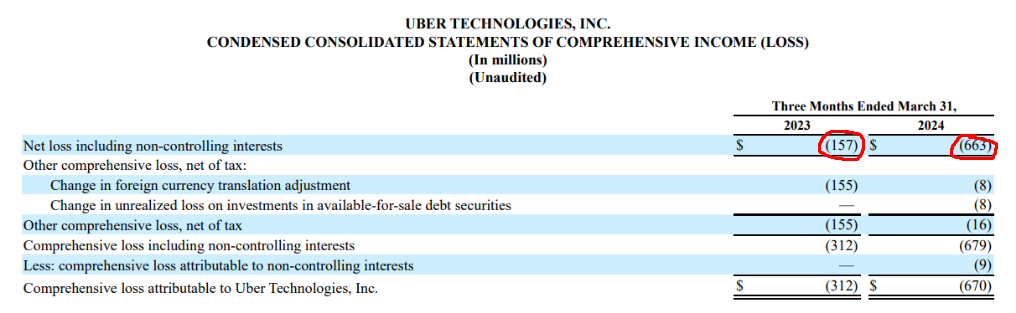

In [ ]:
response = qa.invoke({"query":"what is the Net cash used in operating activities for March 31,2024? "})
response['result']

'Net cash provided by operating activities was $1.4 billion for the three months ended March 31, 2024.'

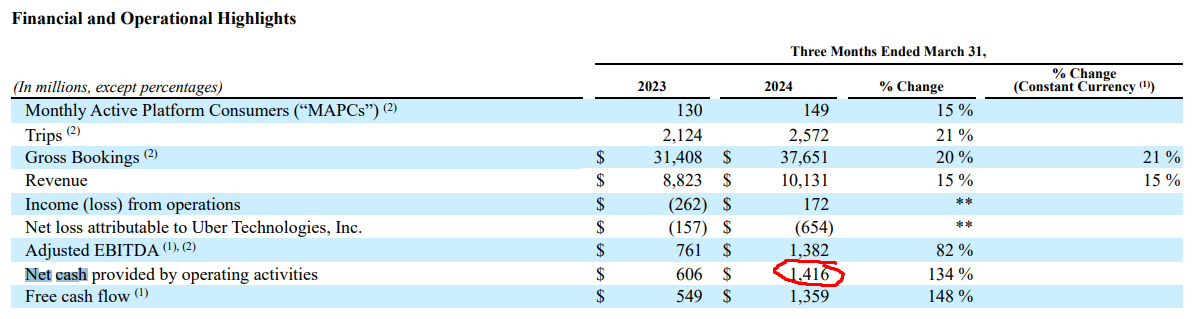

In [ ]:
query = "Based on the CONDENSED CONSOLIDATED STATEMENTS OF CASH FLOWS What is the value of Purchases of property and equipment of each year?"
response = qa.invoke({"query":query})
response['result']

'The value of Purchases of property and equipment for the three months ended March 31, 2023 is $(57) million, and for the three months ended March 31, 2024 is $(57) million.'

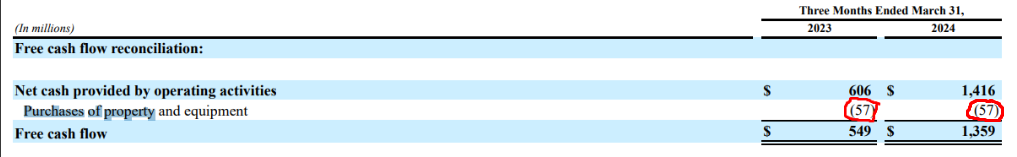